# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import col,isnan, when, count, udf, datediff, first, col, desc, sum as Fsum, max as Fmax, min as Fmin,countDistinct, rand
import datetime
from pyspark.sql.window import Window
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.types import IntegerType, DateType
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = 'mini_sparkify_event_data.json'
data = spark.read.json(path)

In [4]:
data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
#Get nulls
nulls_pandas = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas()
nulls_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [6]:
#check users again
data.groupBy("userId").count().orderBy("userId").show()
#Users with space are null!!

#Get the rows with no space
data_sp = data.filter('userId != ""')
print("Load finished")

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows

Load finished


In [7]:
data_sp.groupBy("userId").count().orderBy("count",ascending=True).show()

+------+-----+
|userId|count|
+------+-----+
|   156|    6|
|   135|    6|
|   125|   11|
|100011|   23|
|300003|   35|
|100024|   36|
|    22|   40|
|   133|   44|
|100006|   44|
|    90|   45|
|    68|   48|
|   134|   52|
|   122|   62|
|    64|   68|
|    34|   73|
|100017|   75|
|200007|   76|
|100003|   78|
|   116|   79|
|200012|   84|
+------+-----+
only showing top 20 rows



In [8]:
#Data with no blank users
data_sp.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
#Get the Schema
data_sp.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
#Get Rows
print(f'Rows {data.count()} ')

Rows 286500 


In [11]:
#FUNCTIONS

#Get clients who cancelled the account (Cancellation Confirmation)
cancellation = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())


#Get clients who downgraded the account (Downgrade)
downgrade = udf(lambda x: 1 if x =="Downgrade" else 0, IntegerType())


#Flag to downgrade
flag_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0,IntegerType())

#Transform TS to date
ts_date = udf(lambda x: datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))


#Get the difference between two dates
datediff_event = udf(lambda x,y: datediff(col(x),col(y)))


#Get when user plays a song
next_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())


#Churned user
churned = udf(lambda x: 1 if x > 0  else 0, IntegerType())

window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [12]:
data_sp = data_sp.withColumn("submit_downgrade",flag_downgrade("page"))\
    .withColumn("cancellation",cancellation("page"))\
    .withColumn("ts_date",ts_date("ts"))\
    .withColumn("registration_date",ts_date("registration"))\
    .withColumn("datediff",datediff(col("ts_date"),col("registration_date")))\
    .withColumn("phase", Fsum("submit_downgrade").over(window))

users_churned = data_sp.select("userId").filter("page == 'Cancellation Confirmation' or page == 'Submit Downgrade'").groupBy("userId").count().withColumnRenamed('count', 'countChurnPage')
data_sp = data_sp.join(users_churned,on=["userId"],how="left")
data_sp = data_sp.na.fill(value=0,subset=["countChurnPage"])
data_sp = data_sp.withColumn("userChurn",churned("countChurnPage"))
data_sp.na.fill(value=0,subset=["userChurn"])

data_sp.show(5)

+------+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+----------------+------------+-------------------+-------------------+--------+-----+--------------+---------+
|userId|    artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|               song|status|           ts|           userAgent|submit_downgrade|cancellation|            ts_date|  registration_date|datediff|phase|countChurnPage|userChurn|
+------+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+----------------+------------+-------------------+-------------------+--------+-----+--------------+---------+
|100010|      null|Logged In| D

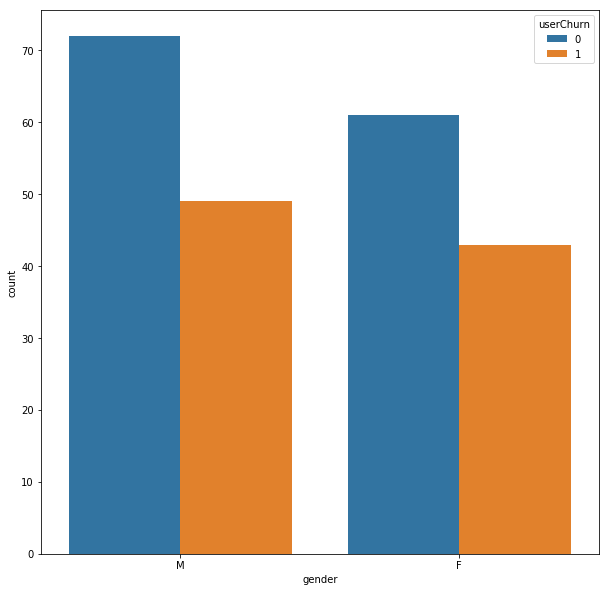

In [20]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='gender',
                    y='count',
                    hue="userChurn",
                    data=data_sp.select("userId","gender","userChurn").distinct().groupby(['gender',"userChurn"]).count().toPandas())

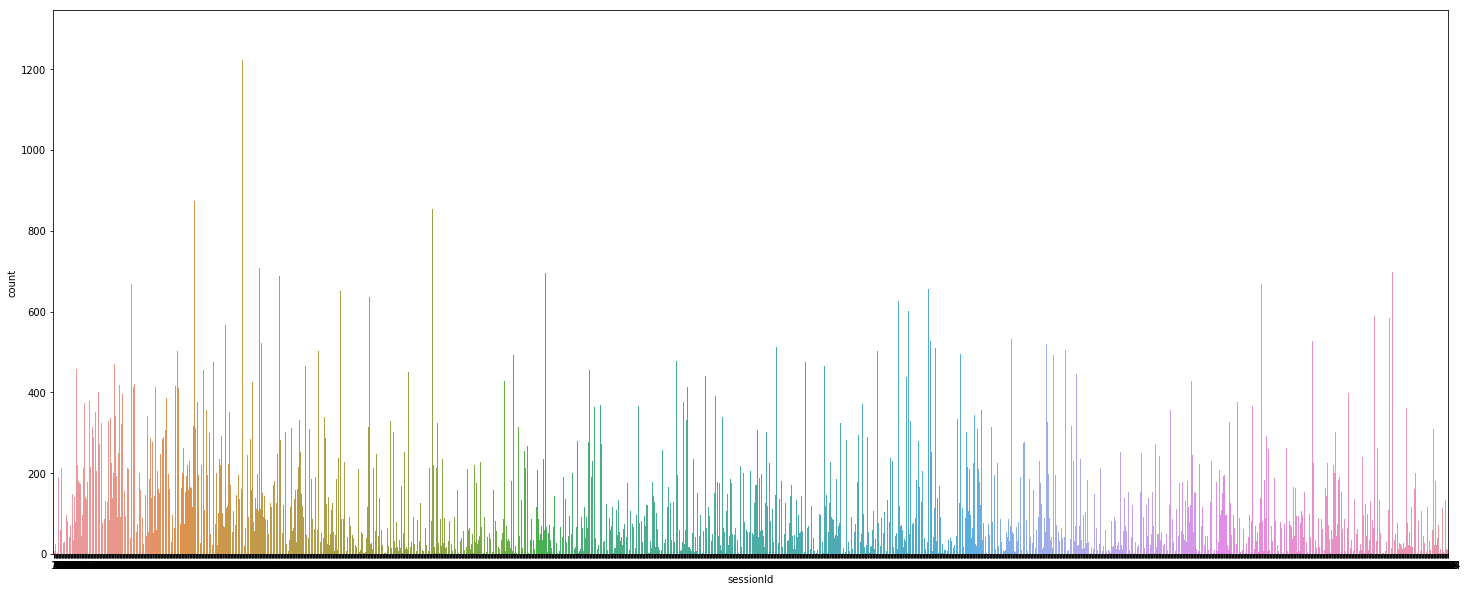

In [14]:
#count of sessions by sessionId
fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)

#Page counts 
graph = sns.barplot(
            x='sessionId',
            y='count',
            ax=ax,
            data=data_sp.groupBy("sessionId").count().orderBy("sessionId",ascending=False).toPandas())

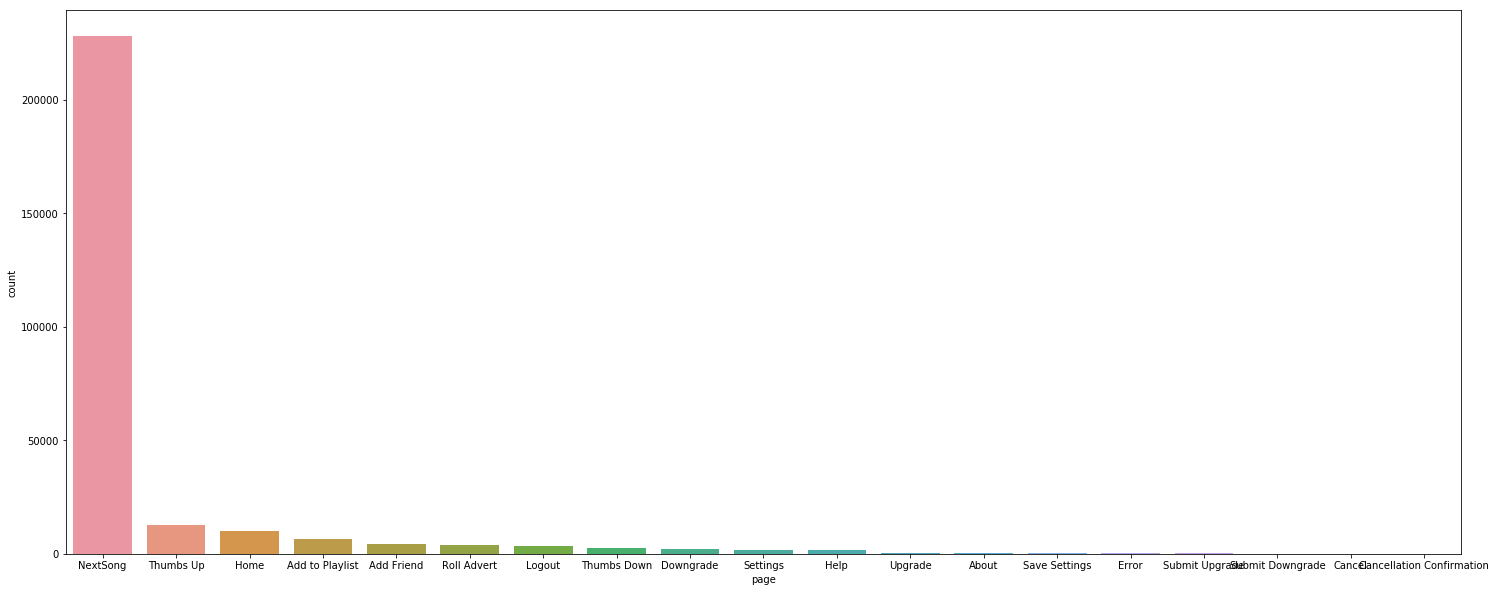

In [15]:
#count of pages visited
fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)

#Page counts 
graph = sns.barplot(
            x='page',
            y='count',
            ax=ax,
            data=data_sp.groupby("page").count().orderBy("count",ascending=False).toPandas())

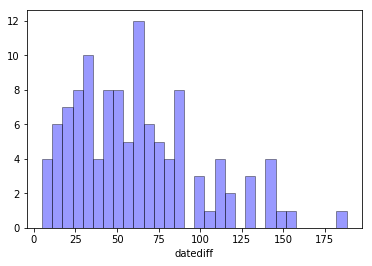

In [16]:
#Get days between registration and churn
data_diff_days = data_sp.filter("submit_downgrade == 1 OR cancellation == 1").toPandas()
sns.distplot(data_diff_days['datediff'], hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.show()

In [17]:
downgrade_1 = data_sp.filter("submit_downgrade == 1")
user_list = downgrade_1.select("userId").distinct().rdd.map(lambda x: x[0]).collect()
user_leave = data_sp.where(col("userId").isin(user_list)).withColumn("next_song",next_song("page"))
user_no_leave = data_sp.where(~col("userId").isin(user_list)).withColumn("next_song",next_song("page"))

In [18]:
#Average of songs played for users who didnt churned the app
user_no_leave.groupby("userId").agg({'next_song':'sum'}).agg({'sum(next_song)':'avg'}).show()

+-------------------+
|avg(sum(next_song))|
+-------------------+
|  801.5511363636364|
+-------------------+



In [19]:
#Average of songs played for users who churned the app
user_leave.groupby("userId").agg({'next_song':'sum'}).agg({'sum(next_song)':'avg'}).show()

+-------------------+
|avg(sum(next_song))|
+-------------------+
| 1776.2244897959183|
+-------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [2]:
def create_dataset(dataset):
    '''
        DESC: THIS FUNCTION IS USED TO GROUP THE DATA TO BE PROCESSED IN A ML ALGORITHM
        INPUT:
            dataset: Dataset to be used by the grouping function
        OUTPUT:
            dataset: New dataset with data grouped
    '''    
    #FUNCTIONS
    #Get clients who cancelled the account (Cancellation Confirmation)
    cancellation = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())
    #Get clients who downgraded the account (Downgrade)
    downgrade = udf(lambda x: 1 if x =="Downgrade" else 0, IntegerType())
    #Flag to downgrade
    flag_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0,IntegerType())
    #Transform TS to date
    ts_date = udf(lambda x: datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    #Get the difference between two dates
    datediff_event = udf(lambda x,y: datediff(col(x),col(y)))
    #Get when user plays a song
    next_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
    window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    
    #COLS
    #Creates cols used to create new features on the dataset
    dataset = dataset.withColumn("submit_downgrade",flag_downgrade("page"))\
    .withColumn("cancellation",cancellation("page"))\
    .withColumn("ts_date",ts_date("ts"))\
    .withColumn("registration_date",ts_date("registration"))\
    .withColumn("datediff",datediff(col("ts_date"),col("registration_date")))\
    .withColumn("phase", Fsum("submit_downgrade").over(window))
    
    #Grouping columns
    songs_played = dataset.select("userId").filter("page == 'NextSong'").groupBy("userId").count().withColumnRenamed('count', 'songsPlayed')
    thumbs_up = dataset.select("userId").filter("page == 'Thumbs Up'").groupBy("userId").count().withColumnRenamed('count', 'thumbsUp')
    thumbs_down = dataset.select("userId").filter("page == 'Thumbs Down'").groupBy("userId").count().withColumnRenamed('count', 'thumbsDown')
    error = dataset.select("userId").filter("page == 'Error'").groupBy("userId").count().withColumnRenamed('count', 'Error')
    help_page = dataset.select("userId").filter("page == 'Help'").groupBy("userId").count().withColumnRenamed('count', 'HelpVisited')
    sessions = dataset.select("userId","sessionId").filter("phase == 0").groupby("userId").agg(countDistinct("sessionId").alias("sessions")).withColumnRenamed('sessions', 'sessions')
    gender_female = dataset.select("userId","gender").groupby('userId').agg(first(when(col('gender') == "F", 1)).alias("female")).withColumnRenamed('female', 'female')
    gender_male = dataset.select("userId","gender").groupby('userId').agg(first(when(col('gender') == "M", 1)).alias("male")).withColumnRenamed('male', 'male')    

    sessions_length = dataset.select("userId","sessionId","ts").groupby(['userId','sessionId']) \
                        .agg(((Fmax('ts') - Fmin('ts'))/1000).alias('sessionlength'))
    avg_user_session = sessions_length.groupby("userId").agg({"sessionlength": "avg"}).withColumnRenamed('avg(sessionlength)', 'avgSessions')
    churn_user = dataset.select("userId").filter("page == 'Cancellation Confirmation'").groupby("UserId").count().withColumnRenamed('count','Churn')

    #Creating dataset
    users = dataset.select("userId").distinct()
    users = users.join(songs_played,on=["userId"],how="left")
    users = users.join(thumbs_up, on=["userId"],how="left")
    users = users.join(thumbs_down,on=["userId"],how="left")
    users = users.join(error,on=["userId"],how="left")
    users = users.join(help_page,on=["userId"],how="left")
    users = users.join(sessions,on=["userId"],how="left")
    users = users.join(gender_female,on=["userId"],how="left")
    users = users.join(gender_male,on=["userId"],how="left")
    users = users.join(avg_user_session,on=["userId"],how="left")
    users = users.join(churn_user,on=['userId'],how="left")
    users = users.na.fill(value=0)
    
    return users
        
    
spark_ml = SparkSession.builder.appName("Sparkify_ml").getOrCreate()
json_data = spark_ml.read.json('mini_sparkify_event_data.json')
new_dataset = create_dataset(json_data)
new_dataset.show(5)

+------+-----------+--------+----------+-----+-----------+--------+------+----+-----------------+-----+
|userId|songsPlayed|thumbsUp|thumbsDown|Error|HelpVisited|sessions|female|male|      avgSessions|Churn|
+------+-----------+--------+----------+-----+-----------+--------+------+----+-----------------+-----+
|100010|        275|      17|         5|    0|          2|       7|     1|   0|           9269.0|    0|
|200002|        387|      21|         6|    0|          2|       6|     0|   1|          15984.0|    0|
|   125|          8|       0|         0|    0|          0|       1|     0|   1|           1774.0|    1|
|   124|       4079|     171|        41|    6|         23|      29|     1|   0|34739.65517241379|    0|
|    51|       2111|     100|        21|    1|         12|      10|     0|   1|          52341.4|    1|
+------+-----------+--------+----------+-----+-----------+--------+------+----+-----------------+-----+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [3]:
#Lets see the distribution of data
new_dataset.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  174|
|    1|   52|
+-----+-----+



In [4]:
#Get the number of churned clients
count_churn = new_dataset.filter('Churn == 1').count()

# two classes with the same size
new_dataset = new_dataset.filter('Churn == 1').union(new_dataset.filter('Churn == 0').sample(1.0,seed=42)\
                                                     .limit(count_churn)).orderBy(rand())

In [5]:
new_dataset.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|   52|
|    1|   52|
+-----+-----+



In [6]:
#Churn must to be removed
numeric_cols = ['songsPlayed','thumbsUp','thumbsDown','Error','HelpVisited','sessions','avgSessions']
categoric_cols = ['female','male']

#female y male columns are those no scalar features
vector = VectorAssembler(inputCols=numeric_cols, outputCol='vct_features_num')
vector_transformed = vector.transform(new_dataset)
std_scaler = StandardScaler(withMean=True, withStd=True, inputCol='vct_features_num', outputCol='scl_features')
scaled_dataset = std_scaler.fit(vector_transformed)
scaled_ds = scaled_dataset.transform(vector_transformed)

#songsPlayed|thumbsUp|thumbsDown|Error|HelpVisited|sessions|female|male|avgSessions|Churn
vector = VectorAssembler(inputCols=categoric_cols+['scl_features'], outputCol='features')
vector_transformed = vector.transform(scaled_ds)
dataset = vector_transformed.select(vector_transformed['Churn'].alias('label'), vector_transformed['features'].alias('features'))
dataset.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[0.0,1.0,-0.85674...|
|    1|[0.0,1.0,-0.16732...|
|    0|[1.0,0.0,0.651843...|
|    0|[0.0,1.0,-0.63694...|
|    1|[0.0,1.0,-0.89644...|
+-----+--------------------+
only showing top 5 rows



In [7]:
train, test = dataset.randomSplit(weights=[0.8,0.2], seed=42)

In [8]:
LR = LogisticRegression(maxIter=25)
DT = DecisionTreeClassifier(seed=42)
RF = RandomForestClassifier(seed=42)
LSVC = LinearSVC()

ev= MulticlassClassificationEvaluator(predictionCol="prediction")

def prediction_function(model,train_set,test_set,evaluator):
    fitted_dataset = model.fit(train_set)
    prediction = fitted_dataset.transform(test_set)
    print("---------------------")
    print("Model: "+ str(model.__class__.__name__))
    print("")
    print("F1:"+ str(ev.evaluate(prediction.select('label','prediction'),{evaluator.metricName: 'f1'})))
    print("Accuracy:"+ str(ev.evaluate(prediction.select('label','prediction'),{evaluator.metricName: 'accuracy'})))
    print("---------------------")
    print("")
    
prediction_function(LR,train,test,ev)
prediction_function(DT,train,test,ev)
prediction_function(RF,train,test,ev)
prediction_function(LSVC,train,test,ev)

---------------------
Model: LogisticRegression

F1:0.6190476190476191
Accuracy:0.6190476190476191
---------------------

---------------------
Model: DecisionTreeClassifier

F1:0.5650793650793651
Accuracy:0.5714285714285714
---------------------

---------------------
Model: RandomForestClassifier

F1:0.6190476190476191
Accuracy:0.6190476190476191
---------------------

---------------------
Model: LinearSVC

F1:0.5650793650793651
Accuracy:0.5714285714285714
---------------------



In [9]:
#Lets improve the best model: Logistic Regression
grid = ParamGridBuilder()\
        .addGrid(LR.regParam, [0.5,0.1, 0.01])\
        .addGrid(LR.maxIter, [25,50, 200])\
        .build()

crossval = CrossValidator(estimator=LR,
                          estimatorParamMaps=grid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=2)
cv_train = crossval.fit(train)
cv_test = cv_train.transform(test)

print('Accuracy: {}'.format(ev.evaluate(cv_test.select('label','prediction'), {ev.metricName: "accuracy"})))
print('F-1 Score:{}'.format(ev.evaluate(cv_test.select('label','prediction'), {ev.metricName: "f1"})))

Accuracy: 0.6190476190476191
F-1 Score:0.6190476190476191


In [10]:
#Get the best parameters
list(zip(grid,cv_train .avgMetrics))

[({Param(parent='LogisticRegression_326f6aa1e3c5', name='regParam', doc='regularization parameter (>= 0).'): 0.5,
   Param(parent='LogisticRegression_326f6aa1e3c5', name='maxIter', doc='max number of iterations (>= 0).'): 25},
  0.3411310924889651),
 ({Param(parent='LogisticRegression_326f6aa1e3c5', name='regParam', doc='regularization parameter (>= 0).'): 0.5,
   Param(parent='LogisticRegression_326f6aa1e3c5', name='maxIter', doc='max number of iterations (>= 0).'): 50},
  0.3411310924889651),
 ({Param(parent='LogisticRegression_326f6aa1e3c5', name='regParam', doc='regularization parameter (>= 0).'): 0.5,
   Param(parent='LogisticRegression_326f6aa1e3c5', name='maxIter', doc='max number of iterations (>= 0).'): 200},
  0.3411310924889651),
 ({Param(parent='LogisticRegression_326f6aa1e3c5', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LogisticRegression_326f6aa1e3c5', name='maxIter', doc='max number of iterations (>= 0).'): 25},
  0.4300174312583663),

In [11]:
#Using best parameter to train the model
#We are going to use regParam = 0.01, max_Iter=200
LR = LogisticRegression(maxIter=200,regParam=0.01)
prediction_function(LR,train,test,ev)

---------------------
Model: LogisticRegression

F1:0.6190476190476191
Accuracy:0.6190476190476191
---------------------



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [15]:
print("Finished")

Finished
